In [4]:
import os
import sys
import numpy as np
import numexpr as ne
import matplotlib.pyplot as plt
import line_profiler
#import memory_profiler
import multiprocessing
from mpi4py import MPI
from numba import jit, prange
import scalene

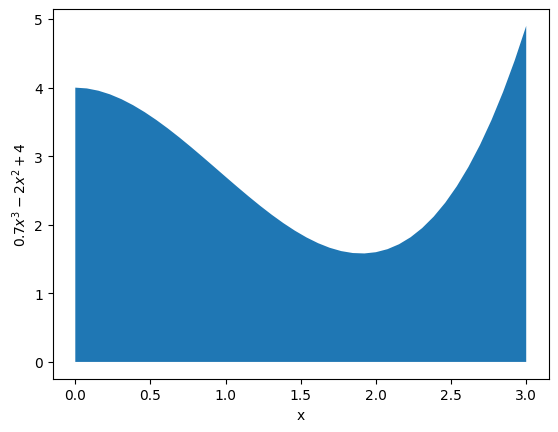

In [5]:
def f(x):
    return 0.7*x*x*x - 2*x*x + 4

X = np.linspace(0,3,40)
Y = f(X)
plt.fill_between(X,Y)
plt.xlabel("x")
plt.ylabel("$0.7x^3-2x^2+4$");

In [6]:
def auc(ntot):
    dx    = 3.0/ntot
    width = 3.0
    x = 0
    a = 0.0
    for i in range(ntot):
        y = 0.7*x**3 - 2*x**2 + 4
        a += y*dx
        x += dx
    print("The area is %f"%a)

In [7]:
ntot=100000000
%time auc(ntot)

The area is 8.175000
CPU times: user 37.2 s, sys: 18.3 ms, total: 37.2 s
Wall time: 37.2 s


In [9]:
import line_profiler

In [10]:
%lprun -f auc auc(1_000_000)

The area is 8.174999


Timer unit: 1e-06 s

Total time: 2.95573 s
File: /tmp/ipykernel_25515/95140975.py
Function: auc at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def auc(ntot):
     2         1          7.0      7.0      0.0      dx    = 3.0/ntot
     3         1          2.0      2.0      0.0      width = 3.0
     4         1          1.0      1.0      0.0      x = 0
     5         1          2.0      2.0      0.0      a = 0.0
     6   1000001     617715.0      0.6     20.9      for i in range(ntot):
     7   1000000    1014538.0      1.0     34.3          y = 0.7*x**3 - 2*x**2 + 4
     8   1000000     687335.0      0.7     23.3          a += y*dx
     9   1000000     636044.0      0.6     21.5          x += dx
    10         1         87.0     87.0      0.0      print("The area is %f"%a)

In [12]:
import numpy as np

In [36]:
n_tot = 20000000

In [24]:
def auc_ne(n_tot):
    dx    = 3.0/n_tot
    width = 3.0
    x = np.linspace(0.0, width, n_tot, endpoint=False)
    y = 0.7*x**3 - 2*x**2 + 4
    a = np.sum(y)*dx
    print("The area is %f"%a)

In [28]:
%time auc_ne(n_tot)

The area is 8.174326
CPU times: user 2.36 ms, sys: 1.08 ms, total: 3.44 ms
Wall time: 2.29 ms


In [30]:
def auc_nume(n_tot):
    dx    = 3.0/n_tot
    width = 3.0
    x = np.linspace(0.0, width, n_tot, endpoint=False)
    y = ne.evaluate('0.7*x**3 - 2*x**2 + 4')
    a = np.sum(y)*dx
    print("The area is %f"%a)

In [33]:
ne.set_num_threads(3)

8

In [37]:
%time auc_nume(n_tot)

The area is 8.175000
CPU times: user 223 ms, sys: 112 ms, total: 335 ms
Wall time: 208 ms


In [ ]:
%%file auc_mpi
import numpy as np
import numexpr as ne
n_tot = 20000000
def auc_mpi(n_tot, rank, size, comm):
    dx    = 3.0/n_tot
    width = 3.0
    start = (width/size)*rank
    stop = (width/size)*(rank+1)
    n = n_tot/size
    x = np.linspace(0.0, width, n_tot, endpoint=False)
    a = ne.evaluate('0.7*x**3 - 2*x**2 + 4').sum * dx
    suma = comm.reduce(a,root=0)
    if (rank=0):
        print("The area is %f"%a)
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()
auc_mpi(n_tot)

In [ ]:
!srun -n 3 python auc_mpi